# ***Multi-Agent Supervisor Architecture 🏗️***

### Overview 📋

The Multi-Agent Supervisor Architecture is a distributed system design pattern where multiple autonomous agents operate under the coordination of a central supervisor agent. This architecture enables complex task decomposition, parallel processing, and intelligent orchestration of specialized agents working toward common objectives.

## ***Core Components 🔧***

1. **Supervisor Agent 👨‍💼**
The central coordinator that manages the entire system:

- Task Distribution: Breaks down complex problems into manageable subtasks
- Agent Orchestration: Coordinates communication and workflow between agents
- Resource Management: Allocates computational resources and manages priorities
- Quality Control: Monitors performance and ensures task completion
- Conflict Resolution: Handles disputes and deadlocks between agents

---

2. ***Worker Agents 🤖***

Specialized autonomous units that execute specific tasks:

- Domain Expertise: Each agent focuses on particular capabilities or knowledge areas
- Independent Processing: Can make decisions within their scope of responsibility
- Communication Interface: Maintains channels with supervisor and peer agents
- State Management: Tracks progress and maintains internal state
- Feedback Mechanism: Reports results and status updates

---

3. ***Communication Layer 📡***

The message passing infrastructure that enables coordination:

- Protocol Standards: Defines message formats and communication rules
- Routing Logic: Ensures messages reach intended recipients
- Load Balancing: Distributes communication overhead efficiently
- Error Handling: Manages failed transmissions and timeouts

---

### ***Common Use Cases 🌍***
- Enterprise Applications 🏢

    - Customer service systems with specialized agents for different departments
    - Supply chain management with agents handling inventory, logistics, and procurement
    - Financial trading platforms with agents for analysis, execution, and risk management

- Research and Development 🔬

    - Scientific simulations with agents modeling different phenomena
    - Data analysis pipelines with specialized preprocessing, analysis, and visualization agents
    - AI model training with agents handling different aspects of the learning process

- Smart Systems 🏠

    - Home automation with agents controlling lighting, temperature, security, and entertainment
    - Traffic management with agents monitoring different intersections and routes
    - Industrial IoT with agents managing sensors, actuators, and control systems

---
---

In [21]:
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool

load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

tavily_search = TavilySearchResults(max_results=2)

python_repl_tool = PythonREPLTool()

In [22]:
python_repl_tool.invoke("x =4; y=5 ; print(x+y)")

'9\n'

In [23]:
class Supervisor(BaseModel):
    next : Literal["enhancer", "researcher", "coder"] = Field( description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer' when user input requires clarification, expansion, or refinement, "
                    "'researcher' when additional facts, context, or data collection is necessary, "
                    "'coder' when implementation, computation, or technical problem-solving is required."
    )

    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

In [24]:
def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:

    system_prompt = ('''
                 
        You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
        3. **Coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
    ''')

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"] 

    response = llm.with_structured_output(Supervisor).invoke(messages)

    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  
    )
    

In [25]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
   
    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]  

    enhanced_query = llm.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor", 
    )

In [26]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    research_agent = create_react_agent(
        llm,  
        tools=[tavily_search],  
        state_modifier= "You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. Organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator", 
    )

In [27]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:

    code_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        state_modifier=(
            "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )

In [28]:
# System prompt providing clear instructions to the validator agent
system_prompt = '''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'FINISH' in all other cases to end the workflow.
'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END  
        print(" --- Transitioning to END ---")  
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto, 
    )

In [29]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node) 
graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile()

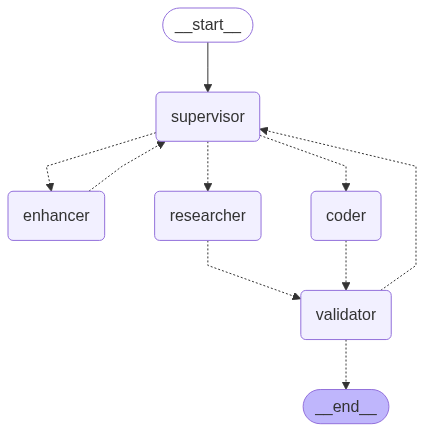

In [30]:
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 


In [31]:
import pprint

inputs = {
    "messages": [
        ("user", "Weather in Delhi"),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()
     

--- Workflow Transition: Supervisor → ENHANCER ---
"Output from node 'supervisor':"
HumanMessage(content='The user request "Weather in Delhi" is quite broad and lacks specificity. The Prompt Enhancer can help refine this request by determining whether the user is interested in the current weather, a forecast for a specific period, historical weather data, or some other weather-related information about Delhi. Clarifying this will provide a more precise direction for the Researcher to gather the appropriate data.', additional_kwargs={}, response_metadata={}, name='supervisor', id='adbeb752-afed-4cc0-aabf-3487a44c8ae5')

--- Workflow Transition: Prompt Enhancer → Supervisor ---
"Output from node 'enhancer':"
HumanMessage(content='Provide a detailed report on the current weather conditions in Delhi, including key elements such as temperature, humidity, wind speed, visibility, and any weather advisories. Additionally, include a 7-day forecast outlining expected temperature ranges, precipit

In [32]:
import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Workflow Transition: Supervisor → CODER ---
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's request is to compute the 20th Fibonacci number. This task directly involves calculations and algorithmic solutions, which is the specialty of the Coder agent. No additional clarification or information gathering is needed, as the problem statement is clear and straightforward.", additional_kwargs={}, response_metadata={}, name='supervisor', id='565aa3f6-cf7d-4fe8-8c83-44841c4e665d')]}

--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='coder', id='c4111b66-9cbc-49e5-b586-f848c616b912')]}

 --- Transitioning to END ---
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The answer correctly provides the 20th Fibonacci number, 6765, which directly addresses the user’s request.', additional_kwargs={}, response_metadata={}, name='

In [34]:
import pprint

inputs = {
    "messages": [
        ("user", "give me python code to print a table of 5"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Workflow Transition: Supervisor → CODER ---
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's request is clear and specific: they are asking for Python code to print a table of 5. This requires a direct technical implementation, which falls under the expertise of the Coder. There is no need for clarification or additional research as the task is straightforward and unambiguous.", additional_kwargs={}, response_metadata={}, name='supervisor', id='2e4441ec-1642-4c75-8682-cd5476b5af35')]}

--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content="Here's the Python code to print the multiplication table of 5:\n\n```python\nfor i in range(1, 11):\n    print(f'5 x {i} = {5 * i}')\n```\n\nWhen executed, this code will print:\n\n```\n5 x 1 = 5\n5 x 2 = 10\n5 x 3 = 15\n5 x 4 = 20\n5 x 5 = 25\n5 x 6 = 30\n5 x 7 = 35\n5 x 8 = 40\n5 x 9 = 45\n5 x 10 = 50\n```", additional_kwargs={}, response_metadata={}, nam

In [35]:
import pprint

inputs = {
    "messages": [
        ("user", "take iput from me and print the table of that number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Workflow Transition: Supervisor → ENHANCER ---
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content='The request needs clarification and structuring. We should refine the input to specify the programming language for the table generation, the range of the table (how far the multiplication should go), and whether there are any formatting requirements for the output. Once the input is clear, the coder can effectively implement the solution.', additional_kwargs={}, response_metadata={}, name='supervisor', id='3ec8b321-ed05-429f-9e89-5c704c1d01e6')]}

--- Workflow Transition: Prompt Enhancer → Supervisor ---
"Output from node 'enhancer':"
{ 'messages': [ HumanMessage(content='To print the multiplication table of a number provided by the user, we will assume you want a basic program written in Python. This program will take an integer input from the user and print the multiplication table for that number, from 1 to 10. Here is the refined process and code:\n\n1. **Input